# Excess Power
The following is taken from U.S. Naval Test Pilot School. ‘USNTPS Fixed Wing Performance (USNTPS-FTM-NO. 108)’. In U.S. Naval Test Pilot School Flight Test Manual, 1992.

## Required Equations

Equations for Level Acceleration Data Reduction

1. **Dynamic Pressure (qc):**
   $$
   q_c = P_{\text{ssl}} \left\{ \left[ 1 + 0.2 \left( \frac{V_c}{a_{\text{ssl}}} \right)^2 \right]^{3.5} - 1 \right\}
   $$

2. **Ambient Pressure (Pa):**
   $$
   P_a = P_{\text{ssl}} \left( 1 - 6.8755856 \times 10^{-6} H_p \right)^{5.255863}
   $$

3. **Mach Number (M):**
   $$
   M = \sqrt{\frac{2}{\gamma - 1} \left[ \left( \frac{q_c}{P_a} + 1 \right)^{\frac{\gamma - 1}{\gamma}} - 1 \right]}
   $$

4. **Ambient Temperature (Ta):**
   $$
   T_a = \frac{\text{OAT} + 273.15}{1 + \frac{\gamma - 1}{2} K_T M^2}
   $$

5. **Altitude Correction (h):**
   $$
   h = H_p \frac{T_{a_{\text{Test}}}}{T_{a_{\text{Std}}}}
   $$

6. **True Airspeed (VT):**
   $$
   V_T = M \sqrt{\gamma g_c R T_a}
   $$

1. **Energy Height**
$$
E_h = h+\frac{V^2_T}{2g}
$$

### Variables

- $a_{\text{ssl}}$: Standard sea level speed of sound - 661.483 kn
- $E_h$: Energy height - ft
- $g$: Gravitational acceleration - ft/s²
- $\gamma$: Ratio of specific heats
- $g_c$: Conversion constant - 32.17 $lb_m$/slug
- $h$: Tapeline altitude - ft
- $H_p$: Calibrated pressure altitude - ft
- $K_T$: Temperature recovery factor
- $M$: Mach number
- OAT: Outside air temperature - °C
- $P_a$: Ambient pressure - psf
- $P_{\text{ssl}}$: Standard sea level pressure - 2116.217 psf
- $q_c$: Impact pressure - psf
- $R$: Engineering gas constant for air - 96.93 ft-lbf/$lb_m$-°K
- $T_a$: Ambient temperature - °K
- $T_{\text{aStd}}$: Standard ambient temperature - °K
- $T_{\text{aTest}}$: Test ambient temperature - °K
- $V_c$: Calibrated airspeed - kn
- $V_T$: True airspeed - ft/s

## Pilot's Data
The following data is required at intervals throughout the acceleration run:
- Time (s)
- $H_{P_o}$ Pressure Altitude, observed (ft)
- $V_o$ Indicated Airspeed, observed (knots)
- OAT Outside air temperature
- $W_f$ Remaining fuel weight (lbs)


## Order of Analysis

Correct observed altitude and airspeed data to calibrated altitude and airspeed.  Using calibrated altitude, airspeed, and OAT compute Eh as follows:

| Step | Parameter           | Notation | Formula    | Units | Remarks                    |
|------|----------------------|----------|------------|-------|----------------------------|
| 1    | Impact pressure      | $q_c$    | Eq 5.25    | psf   |                            |
| 2    | Ambient pressure     | $P_a$    | Eq 5.26    | psf   |                            |
| 3    | Mach number          | $M$      | Eq 5.27    |       |                            |
| 4    | Ambient temperature  | $T_a$    | Eq 5.28    | °K    | Or from reference source   |
| 5    | Tapeline height      | $h$      | Eq 5.29    | ft    |                            |
| 6    | True airspeed        | $V_T$    | Eq 5.30    | ft/s  |                            |
| 7    | Energy height        | $E_h$    | Eq 5.7     | ft    |                            |

## Output
1. Energy Height vs. Elapsed Time Plot
2. Test Specific Excess Power vs. Mach

## Corrections for non-standard conditions
Corrections for:

1. $W$ for non-standard weight.
1. $V_T$ for non-standard temperature.
1. $T$ for temperature effect on thrust.
1. $D$ for induced drag change resulting from the weight correction.



1. W for non-standard weight
$$
\frac{W_{\text{Test}}}{W_{\text{s}}}
$$

2. T for temperature effect on thrust (computed from engine thrust model)
$$
\Delta T = f(T_a)
$$

3. D for induced drag change resulting from the weight correction
$$
\Delta D = D_{\text{Std}}-D_{\text{Test}} = \frac{2(W_{\text{Std}}^2-W_{\text{Test}}^2)}{\pi e \text{AR}S\gamma P_a M^2}
$$

Which can then be used for:

4. $P_{s_\text{std}}$
$$
P_{s_\text{Std}} = P_{\text{sTest}} \frac{W_{\text{Test}}}{W_{\text{Std}}} \sqrt{\frac{T_{a_{\text{Std}}}}{T_{a_{\text{Test}}}}} + \frac{V_{T_{\text{Std}}}}{W_{\text{Std}}} \left( \Delta T_{N_x} - \Delta D \right)
$$

## Python Code

In [261]:
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt

from atmosphere import Atmosphere

atm = Atmosphere()

### Constants

In [262]:
P_ssl = 2116.217  # psf
a_ssl = atm.kts_to_fps(661.483)  # knots
gamma = 1.4
g = 32.17  # ft/s^2
R = 96.93
T_ssl = 288.15  # K

### Functions

1. **Dynamic Pressure (qc):**
   $$
   q_c = P_{\text{ssl}} \left\{ \left[ 1 + 0.2 \left( \frac{V_c}{a_{\text{ssl}}} \right)^2 \right]^{3.5} - 1 \right\}
   $$

In [263]:
def q_c(v_c):
    return P_ssl * ((1 + 0.2 * (v_c / a_ssl) ** 2) ** 3.5 - 1)

2. **Ambient Pressure (Pa):**
   $$
   P_a = P_{\text{ssl}} \left( 1 - 6.8755856 \times 10^{-6} H_p \right)^{5.255863}
   $$

In [264]:
def P_a(h_p):
    # return P_ssl * (1 - 6.8755856e-6 * h_p) ** 5.255863
    return atm.calc_Pa(h_p)

3. **Mach Number (M):**
   $$
   M = \sqrt{\frac{2}{\gamma - 1} \left[ \left( \frac{q_c}{P_a} + 1 \right)^{\frac{\gamma - 1}{\gamma}} - 1 \right]}
   $$

In [265]:
def mach(q_c, P_a):
    return np.sqrt(2 / (gamma - 1) * (((q_c / P_a) + 1) ** ((gamma - 1) / gamma) - 1))

4. **Ambient Temperature (Ta):**
   $$
   T_a = \frac{\text{OAT} + 273.15}{1 + \frac{\gamma - 1}{2} K_T M^2}
   $$

In [266]:
def T_a(oat, K, M):
    return (oat + 273.15) * (1 + (gamma - 1) / 2 * K * M**2)

5. **Altitude Correction (h):**
   $$
   h = H_p \frac{T_{a_{\text{Test}}}}{T_{a_{\text{Std}}}}
   $$

In [267]:
def h(h_p, T_a_test, T_a_std):
    return h_p * (T_a_test / T_a_std)

6. **True Airspeed (VT):**
   $$
   V_T = M \sqrt{\gamma g_c R T_a}
   $$

In [268]:
def v_t(M, T_a):
    return M * np.sqrt(gamma * g * R * T_a)

7. **Energy Height**
$$
E_h = h+\frac{V^2_T}{2g}
$$

In [269]:
def e_h(h, v_t):
    return h + (v_t**2) / (2 * g)

### Helper Functions

In [270]:
def standardize_columns(df, column_mapping):
    # Rename columns based on the exact mapping
    df.rename(columns=column_mapping, inplace=True)
    return df

### Load Data

In [271]:
# df_accel = pd.read_excel("./demo_data//level_accel_data.xlsx", header=1)
df_accel = pd.read_excel("./demo_data/level_accel_10k_clean.xlsx")
# Exact column names from the spreadsheet as keys, and standardized names as values
column_mapping = {
    # "Column Name in Excel": "Standardized Name"
    "Time": "time",
    "ASL": "Hp_i",
    "IAS": "V_i",
    # "TT [℃]": "oat",
    "fuel": "w_f",
}
df_accel["oat"] = df_accel.apply(
    lambda row: (atm.get_std_theta(row["ASL"]) * atm.T_0) - 273.15, axis=1
)

# For level_accel_data.xlsx
# column_mapping = {
#     # "Column Name in Excel": "Standardized Name"
#     "Time [s]": "time",
#     "Hi [ft]": "Hp_i",
#     "Vi [kts]": "V_i",
#     "TT [℃]": "oat",
#     "Wf [lbs]": "w_f",
# }

# Apply standardization
dfs = [standardize_columns(df, column_mapping) for df in [df_accel]]

### Test Parameters

In [272]:
w_s = 11900  # lb
ZFW = 9000  # lb

### Data Analysis

In [273]:
df_accel["v_i_fps"] = df_accel["V_i"] * 1.68781
df_accel["q_c"] = q_c(df_accel["v_i_fps"])
df_accel["P_a"] = df_accel.apply(lambda row: P_a(row["Hp_i"]), axis=1)
df_accel["M"] = mach(df_accel["q_c"], df_accel["P_a"])
# df_accel["T_a"] = T_a(df_accel["oat"], 0.2, df_accel["M"])
# TODO: Work out what to do about unknown K (recovery factor) value
df_accel["T_a"] = df_accel["oat"] + atm.celsius_kelvin
df_accel["T_a_std"] = df_accel.apply(
    lambda row: atm.get_std_theta(row["Hp_i"]) * atm.T_0, axis=1
)
df_accel["h"] = df_accel.apply(
    lambda row: h(row["Hp_i"], row["T_a"], row["T_a_std"]), axis=1
)
df_accel["v_t_fps"] = v_t(df_accel["M"], df_accel["T_a"])
df_accel["e_h"] = e_h(df_accel["h"], df_accel["v_t_fps"])

df_accel["p_s_test"] = np.gradient(df_accel["e_h"], df_accel["time"])
# df_accel["p_s_test"] = savgol_filter(
#     np.gradient(df_accel["e_h"], df_accel["time"]), len(df_accel) // 5, 2
# )

1. Correct $V_T$ for non standard temperature
$$
V_{T_{\text{Std}}} = V_{T_{\text{test}}} \sqrt{\frac{T_{a_{\text{Std}}}}{T_{a_{\text{Test}}}}}

In [274]:
def v_t_std(v_t_t, T_a_t, T_a_std):
    return v_t_t * np.sqrt(T_a_std / T_a_t)

In [275]:
def ps_std(p_s_t, w_test, w_s, T_a_std, T_a_t, V_t_std, delta_thrust_nx, delta_drag):
    return p_s_t * w_test / w_s * np.sqrt(T_a_std / T_a_t) + V_t_std / w_s * (
        delta_thrust_nx - delta_drag
    )

### Climb Correction Factor

$$
\text{CCF} = 1 + \left( \frac{V_{T_{\text{std}}}}{g} \frac{dV}{dh} \right)
$$

In [276]:
def VbyH(airspeed, height):
    """
    Calculate dV/dH from airspeed in meters per second and height in meters.

    In support of climb correction factor
    """
    dH_raw = np.gradient(height)
    dH = np.where(dH_raw != 0.0, dH_raw, np.nan)  # avoid divide by zero
    return np.gradient(airspeed) / dH


def ccf(true_airspeed_std, height):
    """
    Calculate Climb Correction Factor.

    (Eq 5.50)
    """
    return 1 + ((true_airspeed_std / g) * VbyH(true_airspeed_std, height))

In [277]:
df_accel["v_t_standard"] = df_accel.apply(
    lambda row: v_t_std(row["v_t_fps"], row["T_a"], row["T_a_std"]), axis=1
)
df_accel["W"] = ZFW + df_accel["w_f"]

# NOTE: Assuming delta_thrust_nx and delta_drag are calculated or set to 1 for simplicity
delta_thrust_nx = 1
delta_drag = 1

df_accel["p_s_std"] = df_accel.apply(
    lambda row: ps_std(
        row["p_s_test"],
        row["W"],
        w_s,
        row["T_a_std"],
        row["T_a"],
        row["v_t_standard"],
        delta_thrust_nx,
        delta_drag,
    ),
    axis=1,
)

# TODO: need to add a VbyH function as per Daedalus
# df_accel["VbyH"] = VbyH(df_accel["v_t_standard"], df_accel["h"])
df_accel["ccf"] = ccf(df_accel["v_t_standard"], df_accel["h"])
df_accel["dh/dt_std"] = df_accel["p_s_std"] / df_accel["ccf"]
df_accel["ROC"] = np.gradient(df_accel["h"], df_accel["time"])

# Need dh/dt_test to calculate climb_angle_test
df_accel["climb_angle_test"] = np.arcsin(df_accel["ROC"] / df_accel["v_t_fps"])
df_accel["climb_angle_std"] = np.arcsin(
    df_accel["dh/dt_std"] / df_accel["v_t_standard"]
)

df_accel.to_excel("./output/accel_output.xlsx")

In [278]:
df_accel

,index,Unnamed: 0,time,radalt,rpm,stick_pitch,stick_bank,rud_ped,w_f,throttle,...,e_h,p_s_test,v_t_standard,W,p_s_std,ccf,dh/dt_std,ROC,climb_angle_test,climb_angle_std
0,1803,11811,110.330,9760.7931,104.2926,0.0043,-0.0138,0.0000,3039.5757,1,...,14541.812898,411.816999,553.560106,12039.5757,416.647221,169.117582,2.463654,2.414181,0.004361,0.004451
1,1848,11856,110.739,9761.3825,104.4351,-0.0002,-0.0200,0.0005,3036.8402,1,...,14710.246051,416.884298,563.207112,12036.8402,421.678124,133.134848,3.167301,3.068311,0.005448,0.005624
2,1897,11905,111.188,9759.7193,104.5915,-0.0516,-0.0367,0.0000,3033.7598,1,...,14899.924833,424.785642,573.843881,12033.7598,429.560368,93.639066,4.587406,4.538576,0.007909,0.007994
3,1946,11954,111.636,9758.7055,104.7489,-0.0462,-0.0449,0.0000,3030.6568,1,...,15091.274100,434.741849,584.342158,12030.6568,439.515124,70.808425,6.207102,6.138951,0.010506,0.010623
4,1994,12002,112.084,9760.2037,104.9088,-0.0792,-0.0327,-0.0004,3027.5220,1,...,15289.453530,446.459499,594.983339,12027.5220,451.243819,57.488279,7.849319,7.773259,0.013065,0.013193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,7216,17224,158.529,7358.2300,107.3183,-0.0015,-0.0162,0.0000,2556.4455,1,...,38253.680941,257.714165,1352.739181,11556.4455,250.273924,415.513923,0.602324,0.635632,0.000470,0.000445
80,7407,17415,160.210,7513.7545,107.2756,0.0334,-0.0206,0.0000,2535.7773,1,...,38666.034196,232.803100,1362.492524,11535.7773,225.677707,1119.063719,0.201667,0.233313,0.000171,0.000148
81,7624,17632,162.102,8852.6792,107.2325,0.0283,-0.0196,-0.0004,2512.5181,1,...,39079.880691,205.113830,1372.229384,11512.5181,198.435016,-794.558098,-0.249743,-0.221177,-0.000161,-0.000182
82,7875,17883,164.295,7715.5866,107.1876,0.0438,-0.0199,0.0005,2485.2819,1,...,39495.072023,173.758503,1381.952714,11485.2819,167.702974,-2856.744233,-0.058704,-0.138938,-0.000101,-0.000042



#### Plot

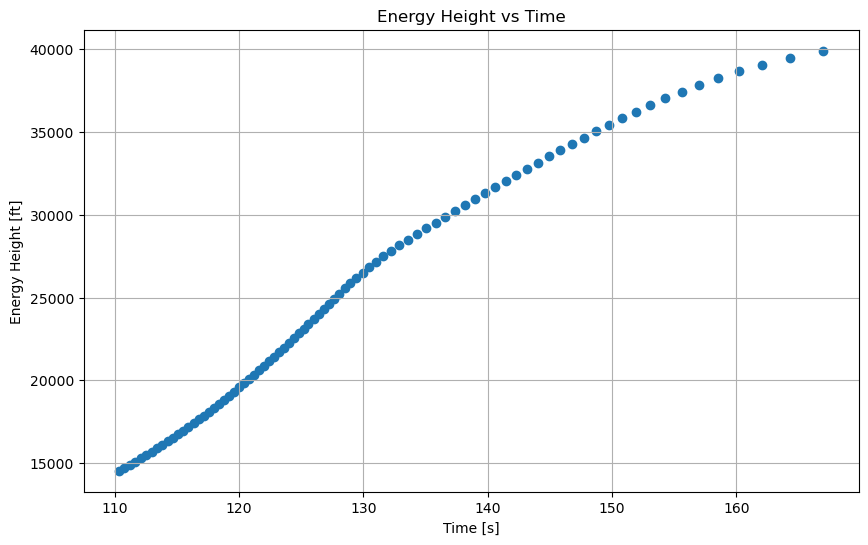

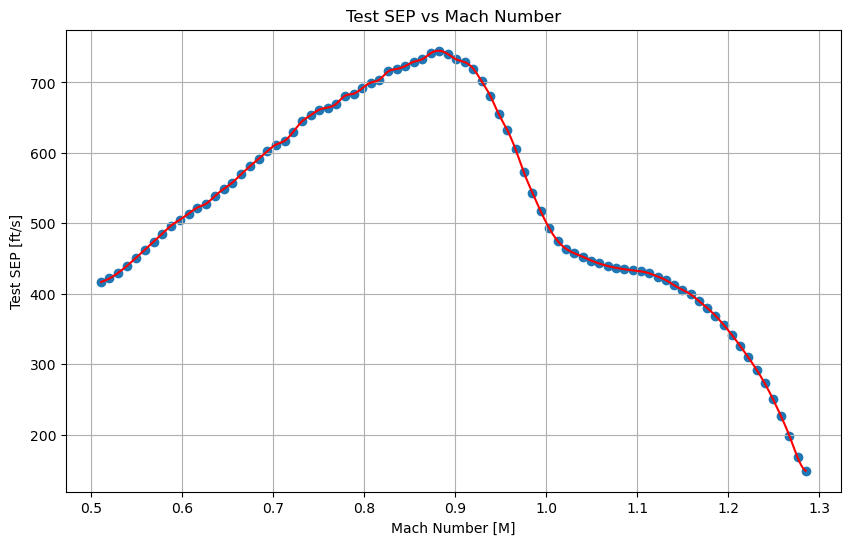

In [279]:
# coefficients = np.polyfit(df_accel["M"], df_accel["p_s_std"], 20)
# polynomial = np.poly1d(coefficients)

# fit_x = np.linspace(df_accel["M"].min(), df_accel["M"].max(), 1000)
# fit_y = polynomial(fit_x)

# Assuming 'mach' and 'sep' are your Mach number and SEP data
mach = np.array(df_accel["M"])  # Replace with actual Mach data
sep = np.array(df_accel["p_s_std"])  # Replace with actual SEP data

# Fit a spline to the data
spline_fit = UnivariateSpline(mach, sep, s=1)  # s=0 forces an exact fit

# Generate smooth data for plotting
mach_smooth = np.linspace(mach.min(), mach.max(), 500)
sep_smooth = spline_fit(mach_smooth)


# Energy Height vs Time
plt.figure(figsize=(10, 6))
plt.scatter(df_accel["time"], df_accel["e_h"])
# plt.plot(fit_x, fit_y)
# plt.plot(df_accel["time"], df_accel["e_h"])
plt.xlabel("Time [s]")
plt.ylabel("Energy Height [ft]")
plt.title("Energy Height vs Time")
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(df_accel["M"], df_accel["p_s_std"])
plt.plot(mach_smooth, sep_smooth, color="red")
plt.xlabel("Mach Number [M]")
plt.ylabel("Test SEP [ft/s]")
plt.title("Test SEP vs Mach Number")
plt.grid()
plt.show()

### Turn Performance

$$
n_{z_\text{sust}} = \sqrt{\frac{P_{s_{1g}} \pi e \text{AR} S 0.7 P_{\text{ssl}} \delta M^2}{V_T W_{\text{std}}}+1}
$$

In [280]:
def n_z_sust(p_s, e, AR, S, P_ssl, delta, M, V_t, W_std):
    return np.sqrt((p_s*np.pi*e*AR*S*0.7*P_ssl*delta*M**2)/(V_t * W_std)+1)

In [281]:
b = 38.1  # wing span [ft]
S = 255  # wing area [ft^2]
AR = b**2 / S  # aspect ratio
e = 0.8  # Oswald efficiency factor
delta = atm.get_std_delta(10000)

df_accel["n_z_sust"] = n_z_sust(df_accel["p_s_std"], e, AR, S, P_ssl, delta, df_accel["M"], df_accel["v_t_standard"], w_s)

### Climb Performance

In [282]:
def climb_angle_to_ROC(climb_angle, v_t_standard):
    return v_t_standard * np.sin(climb_angle) * 60

df_accel["ROC_calc"] = climb_angle_to_ROC(df_accel["climb_angle_std"], df_accel["v_t_standard"])

In [283]:
df_accel

,index,Unnamed: 0,time,radalt,rpm,stick_pitch,stick_bank,rud_ped,w_f,throttle,...,v_t_standard,W,p_s_std,ccf,dh/dt_std,ROC,climb_angle_test,climb_angle_std,n_z_sust,ROC_calc
0,1803,11811,110.330,9760.7931,104.2926,0.0043,-0.0138,0.0000,3039.5757,1,...,553.560106,12039.5757,416.647221,169.117582,2.463654,2.414181,0.004361,0.004451,7.898830,147.819245
1,1848,11856,110.739,9761.3825,104.4351,-0.0002,-0.0200,0.0005,3036.8402,1,...,563.207112,12036.8402,421.678124,133.134848,3.167301,3.068311,0.005448,0.005624,8.013493,190.038055
2,1897,11905,111.188,9759.7193,104.5915,-0.0516,-0.0367,0.0000,3033.7598,1,...,573.843881,12033.7598,429.560368,93.639066,4.587406,4.538576,0.007909,0.007994,8.161788,275.244332
3,1946,11954,111.636,9758.7055,104.7489,-0.0462,-0.0449,0.0000,3030.6568,1,...,584.342158,12030.6568,439.515124,70.808425,6.207102,6.138951,0.010506,0.010623,8.328551,372.426124
4,1994,12002,112.084,9760.2037,104.9088,-0.0792,-0.0327,-0.0004,3027.5220,1,...,594.983339,12027.5220,451.243819,57.488279,7.849319,7.773259,0.013065,0.013193,8.512870,470.959116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,7216,17224,158.529,7358.2300,107.3183,-0.0015,-0.0162,0.0000,2556.4455,1,...,1352.739181,11556.4455,250.273924,415.513923,0.602324,0.635632,0.000470,0.000445,9.546663,36.139428
80,7407,17415,160.210,7513.7545,107.2756,0.0334,-0.0206,0.0000,2535.7773,1,...,1362.492524,11535.7773,225.677707,1119.063719,0.201667,0.233313,0.000171,0.000148,9.103113,12.099992
81,7624,17632,162.102,8852.6792,107.2325,0.0283,-0.0196,-0.0004,2512.5181,1,...,1372.229384,11512.5181,198.435016,-794.558098,-0.249743,-0.221177,-0.000161,-0.000182,8.573130,-14.984557
82,7875,17883,164.295,7715.5866,107.1876,0.0438,-0.0199,0.0005,2485.2819,1,...,1381.952714,11485.2819,167.702974,-2856.744233,-0.058704,-0.138938,-0.000101,-0.000042,7.918601,-3.522254


### NTPS Way

1. Correct $V_i$ for instrument error, position error and compressibility, then true airspeed in ft/s.
1. Plot $V_t$ vs time.
1. As long as no climb/descent during acceleration. Get the gradient of the plot. 

$$
\left. \frac{dH}{dt} \right|_t = SEP = \frac{V_T}{g} \frac{dV_T}{dt}
$$

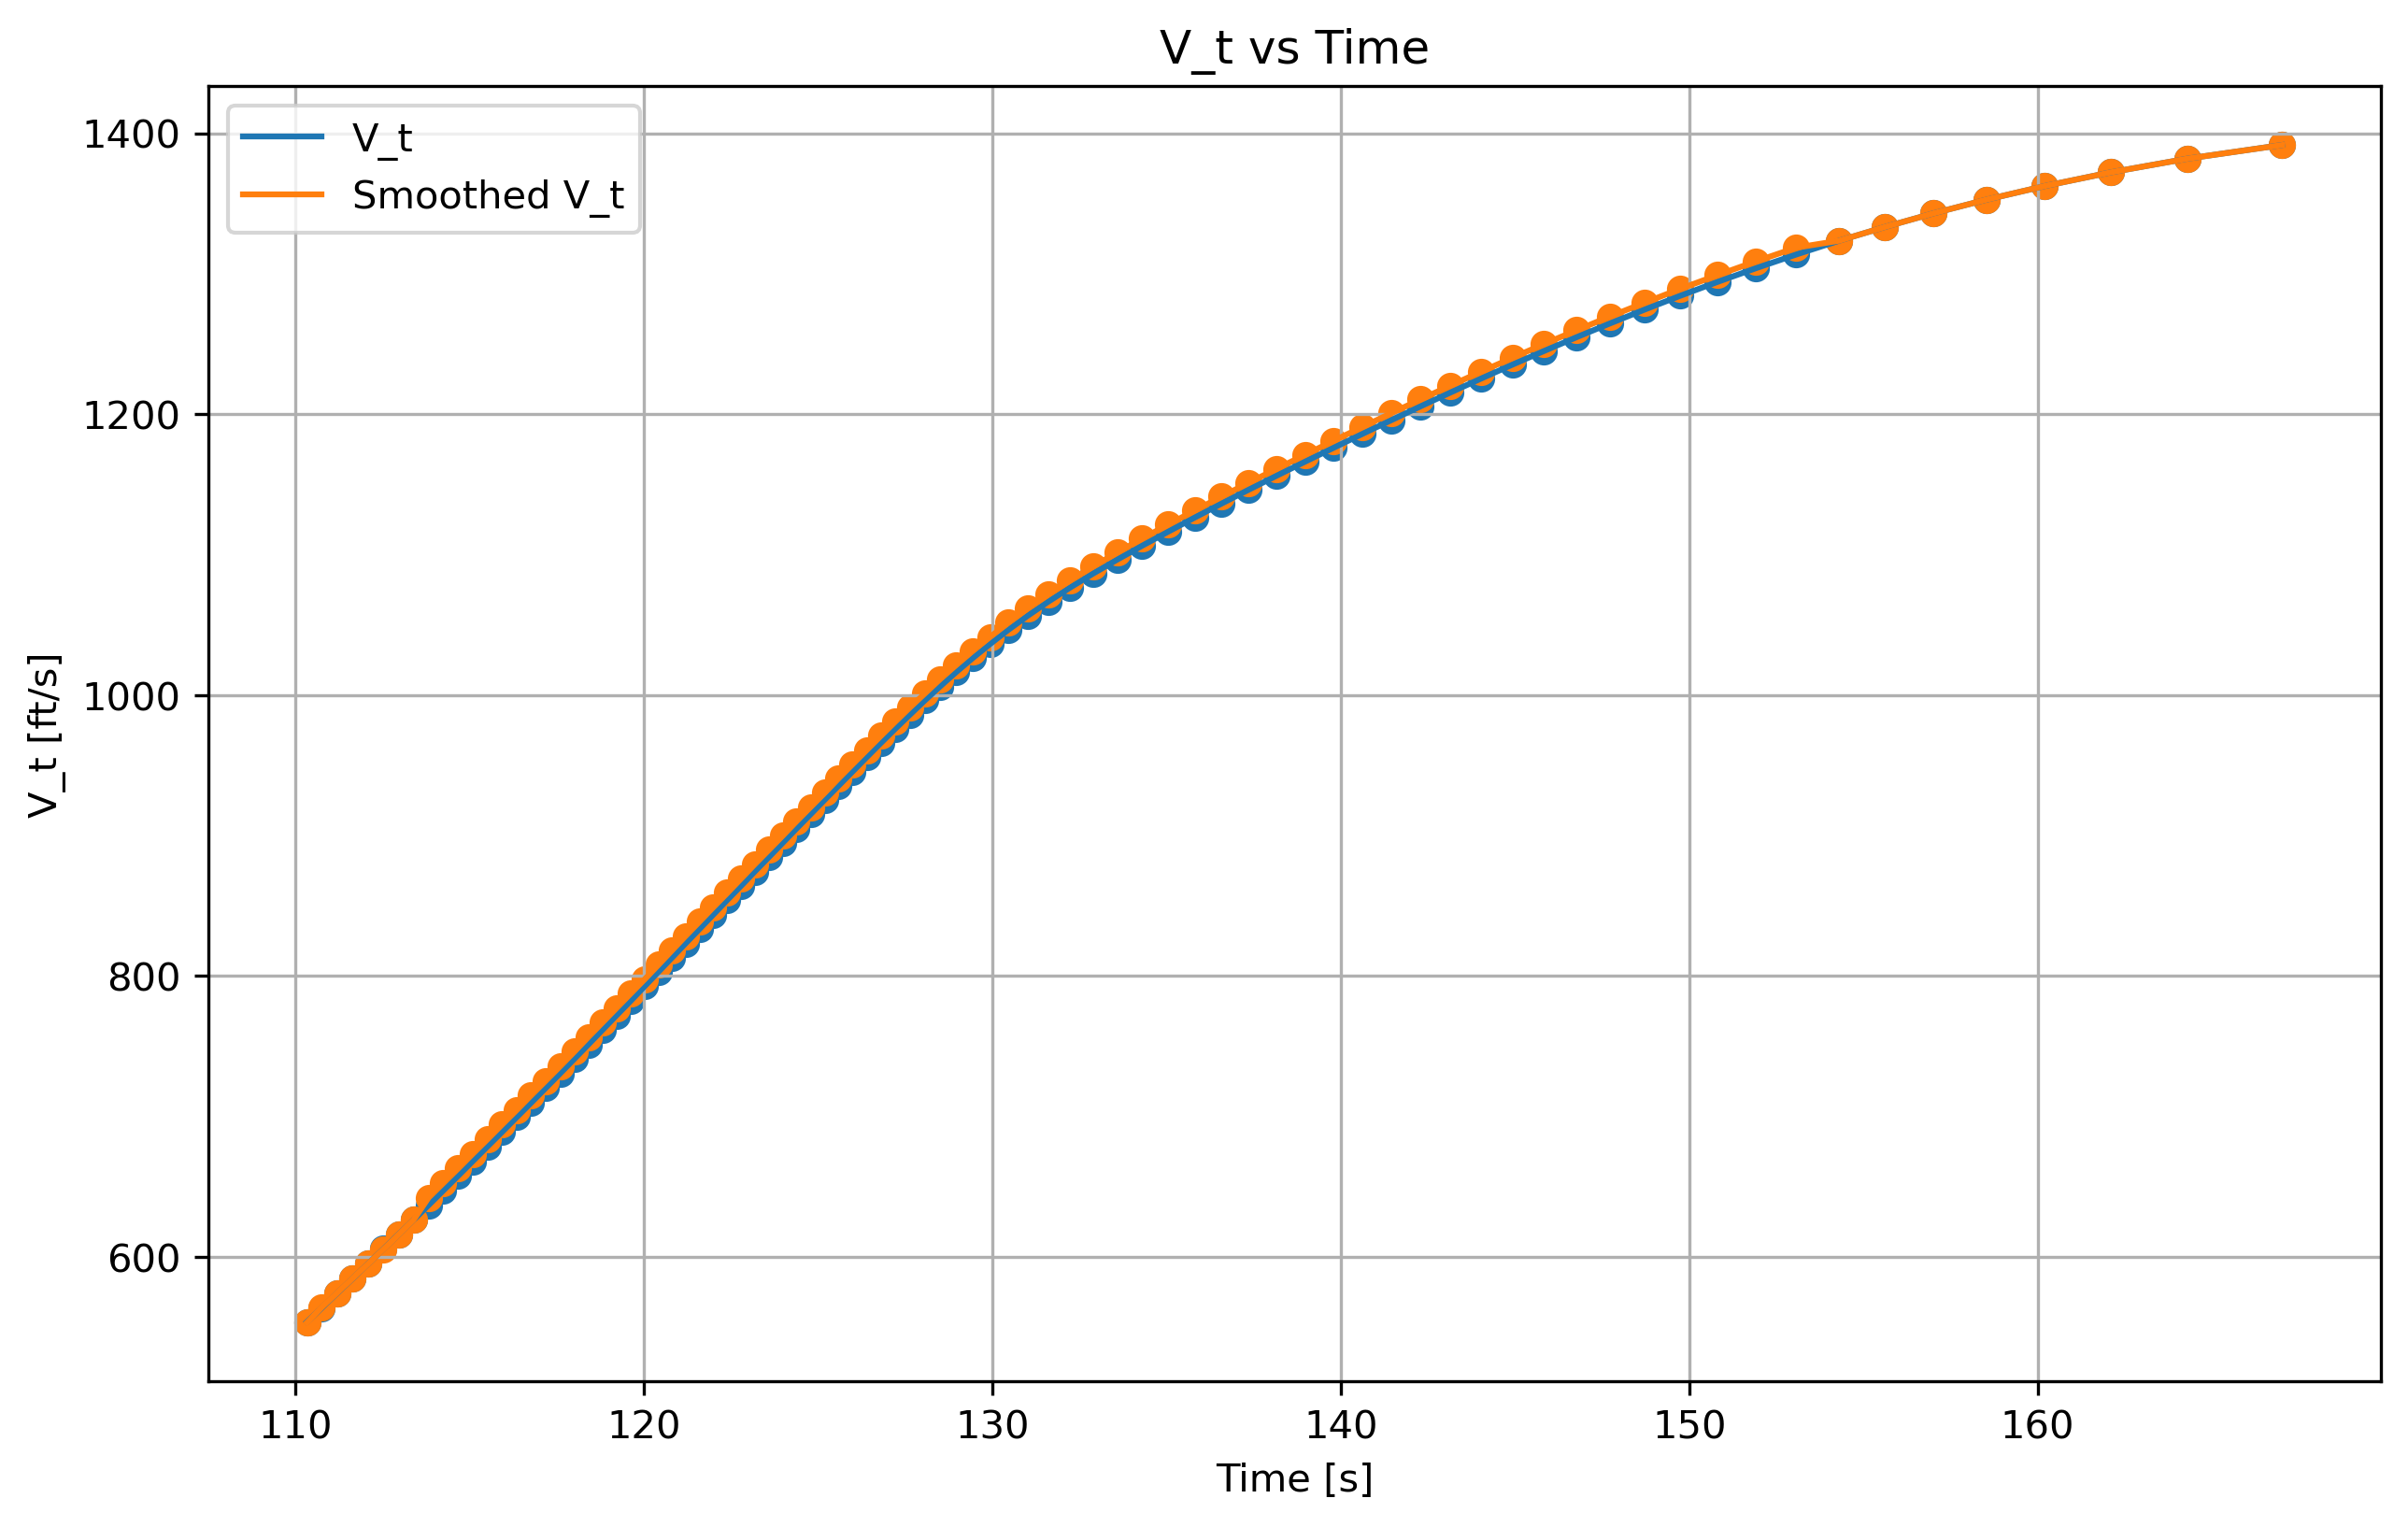

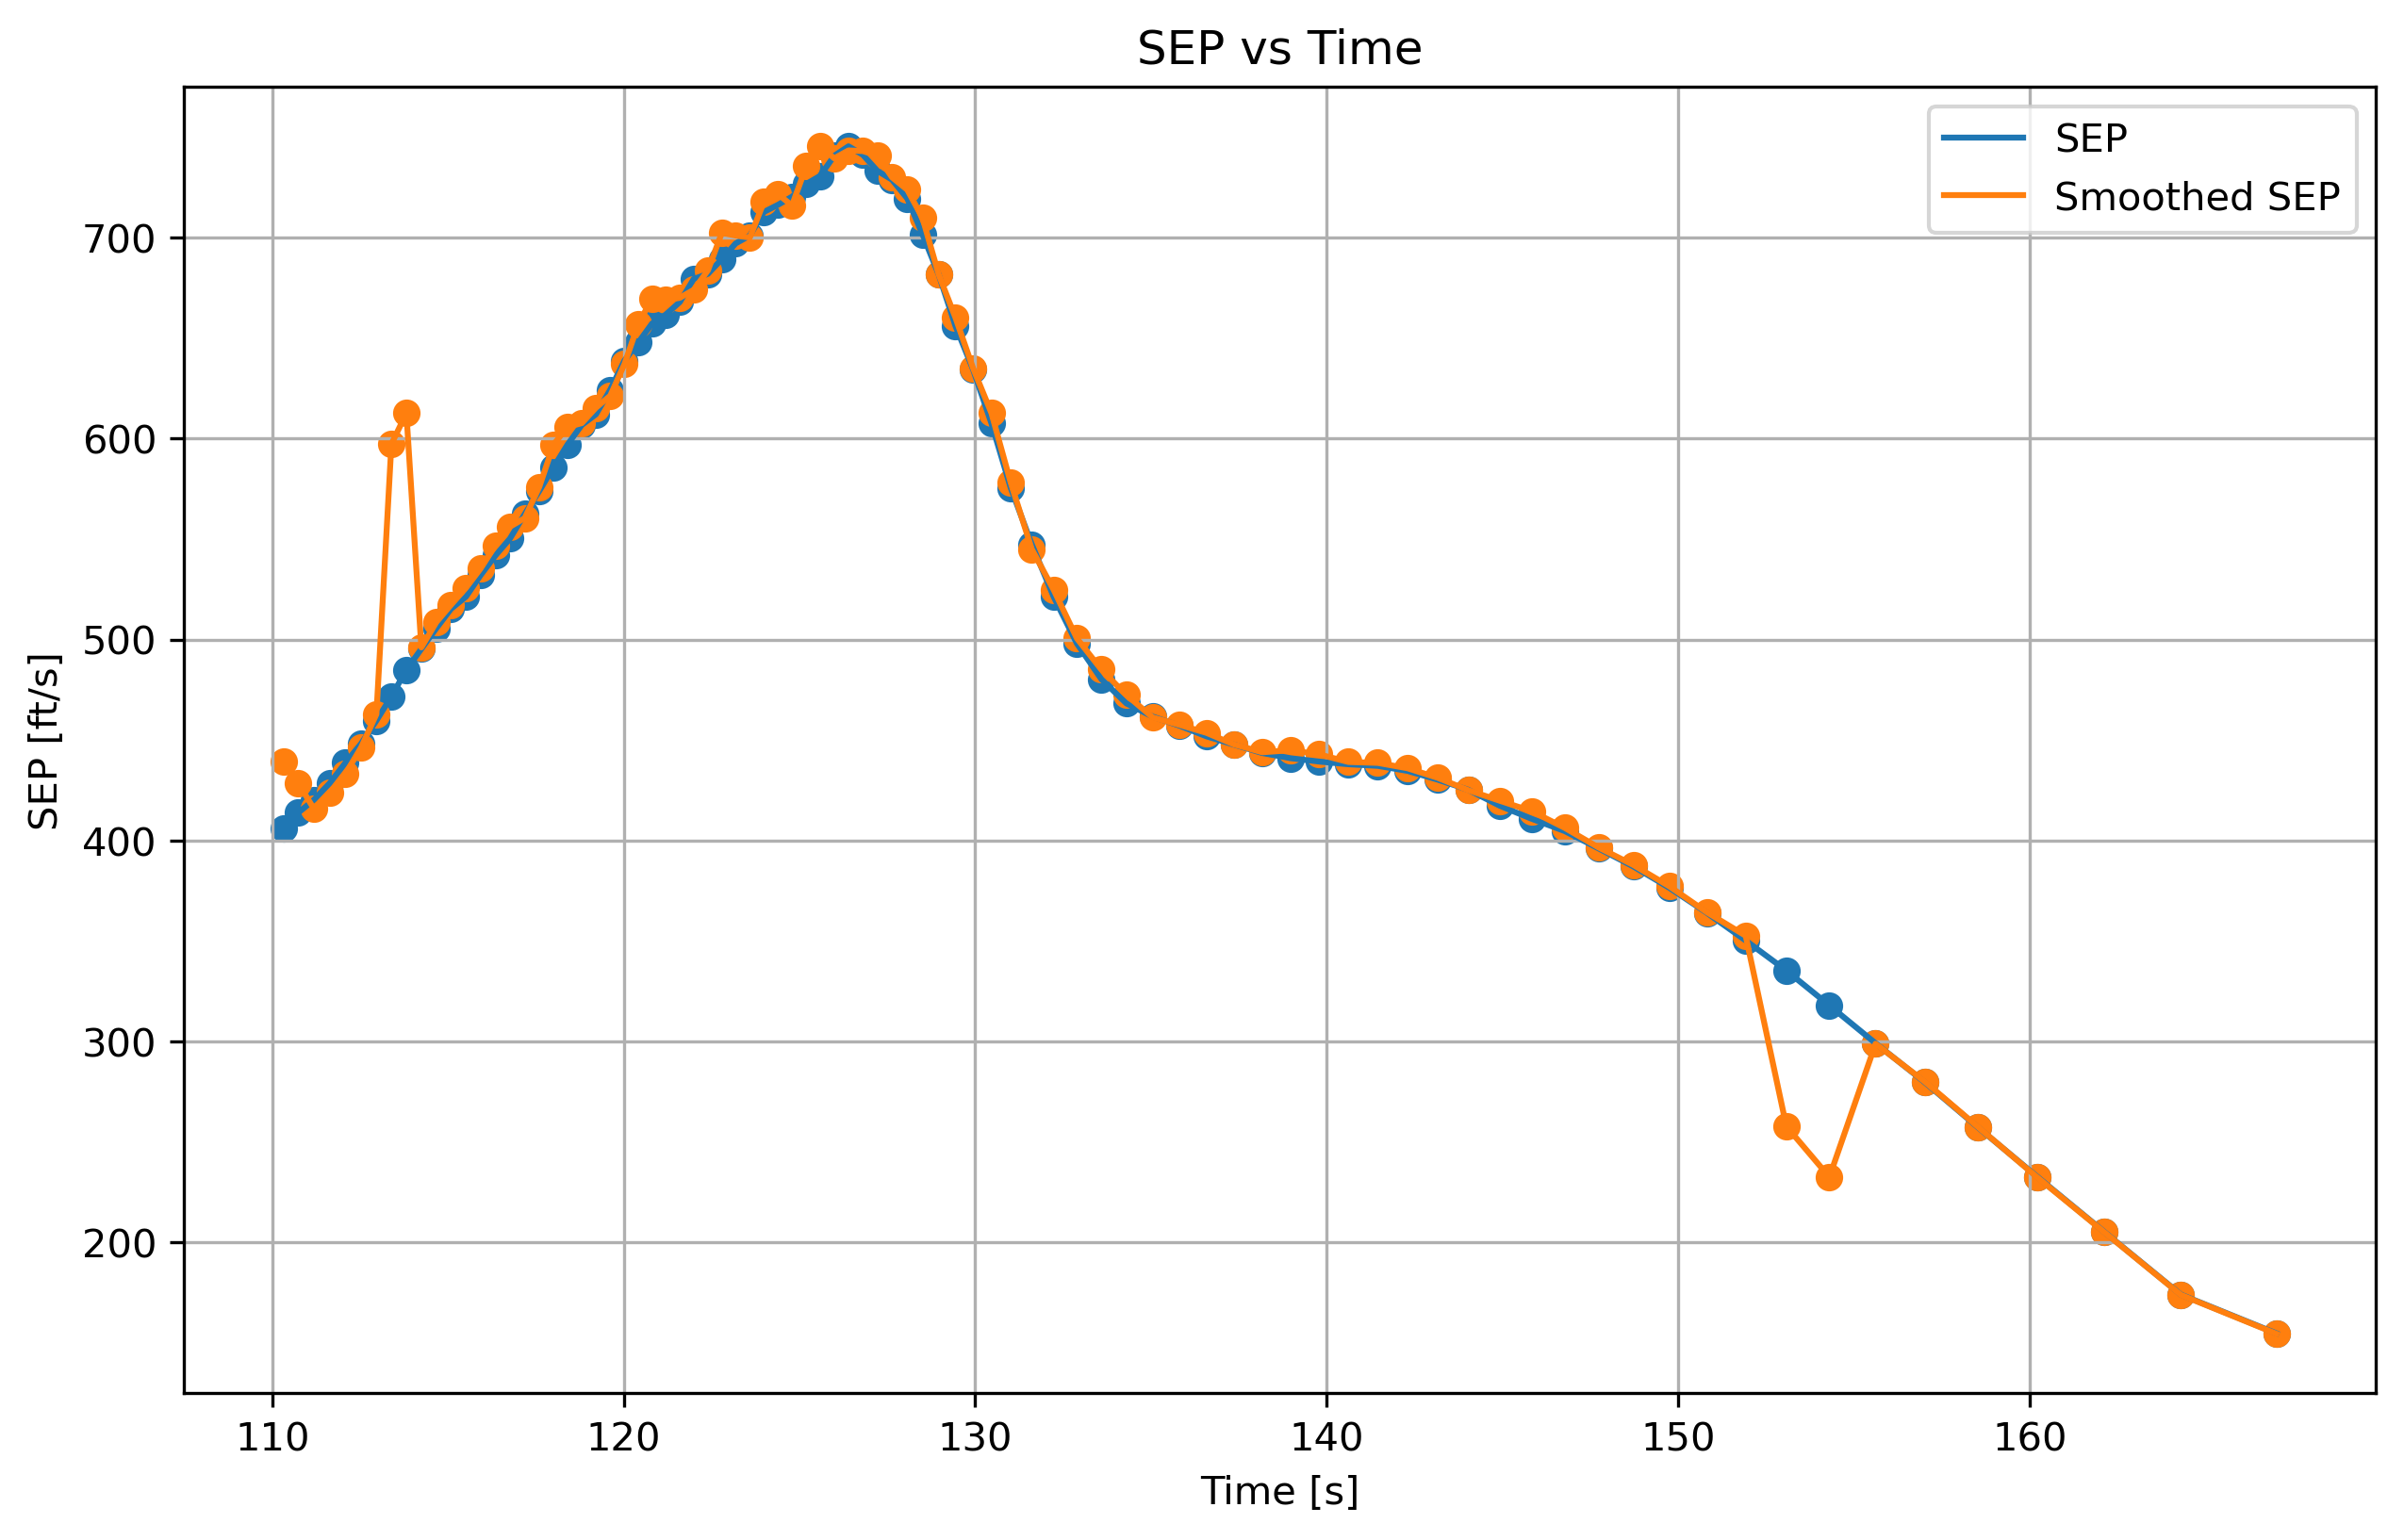

,index,Unnamed: 0,time,radalt,rpm,stick_pitch,stick_bank,rud_ped,w_f,throttle,...,ROC,climb_angle_test,climb_angle_std,n_z_sust,ROC_calc,dV_t/dt,SEP_ntps,sg_vt_fps,sg_dV_t/dt,sg_SEP_ntps
0,1803,11811,110.330,9760.7931,104.2926,0.0043,-0.0138,0.0000,3039.5757,1,...,2.414181,0.004361,0.004451,7.898830,147.819245,23.586811,405.866260,553.127400,25.555243,439.394012
1,1848,11856,110.739,9761.3825,104.4351,-0.0002,-0.0200,0.0005,3036.8402,1,...,3.068311,0.005448,0.005624,8.013493,190.038055,23.635956,413.799773,563.579495,24.468338,428.655689
2,1897,11905,111.188,9759.7193,104.5915,-0.0516,-0.0367,0.0000,3033.7598,1,...,4.538576,0.007909,0.007994,8.161788,275.244332,23.561639,420.289154,574.030030,23.299397,415.746142
3,1946,11954,111.636,9758.7055,104.7489,-0.0462,-0.0449,0.0000,3030.6568,1,...,6.138951,0.010506,0.010623,8.328551,372.426124,23.593145,428.550496,584.479005,23.321865,423.722119
4,1994,12002,112.084,9760.2037,104.9088,-0.0792,-0.0327,-0.0004,3027.5220,1,...,7.773259,0.013065,0.013193,8.512870,470.959116,23.719794,438.696991,594.926421,23.423877,433.182572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,7216,17224,158.529,7358.2300,107.3183,-0.0015,-0.0162,0.0000,2556.4455,1,...,0.635632,0.000470,0.000445,9.546663,36.139428,6.115831,257.168905,1352.764697,6.120777,257.381739
80,7407,17415,160.210,7513.7545,107.2756,0.0334,-0.0206,0.0000,2535.7773,1,...,0.233313,0.000171,0.000148,9.103113,12.099992,5.493583,232.669118,1362.502512,5.486508,232.371181
81,7624,17632,162.102,8852.6792,107.2325,0.0283,-0.0196,-0.0004,2512.5181,1,...,-0.221177,-0.000161,-0.000182,8.573130,-14.984557,4.816319,205.442768,1372.230592,4.812775,205.291780
82,7875,17883,164.295,7715.5866,107.1876,0.0438,-0.0199,0.0005,2485.2819,1,...,-0.138938,-0.000101,-0.000042,7.918601,-3.522254,4.051113,174.026944,1381.948938,4.047694,173.879607


In [284]:
df_accel["dV_t/dt"] = np.gradient(df_accel["v_t_fps"], df_accel["time"])
df_accel["SEP_ntps"] = df_accel["v_t_fps"] / g * df_accel["dV_t/dt"]
df_accel["sg_vt_fps"] = savgol_filter(df_accel["v_t_fps"], len(df_accel) // 5, 2)
df_accel["sg_dV_t/dt"] = np.gradient(df_accel["sg_vt_fps"], df_accel["time"])
df_accel["sg_SEP_ntps"] = df_accel["sg_vt_fps"] / g * df_accel["sg_dV_t/dt"]

plt.figure(figsize=(10, 6), dpi=300)
plt.plot(df_accel["time"], df_accel["v_t_fps"], label="V_t")
plt.plot(df_accel["time"], df_accel["sg_vt_fps"], label="Smoothed V_t")
plt.scatter(df_accel["time"], df_accel["v_t_fps"])
plt.scatter(df_accel["time"], df_accel["sg_vt_fps"])
plt.xlabel("Time [s]")
plt.ylabel("V_t [ft/s]")
plt.title("V_t vs Time")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6), dpi=300)
plt.plot(df_accel["time"], df_accel["SEP_ntps"], label="SEP")
plt.plot(df_accel["time"], df_accel["sg_SEP_ntps"], label="Smoothed SEP")
plt.scatter(df_accel["time"], df_accel["SEP_ntps"])
plt.scatter(df_accel["time"], df_accel["sg_SEP_ntps"])
plt.xlabel("Time [s]")
plt.ylabel("SEP [ft/s]")
plt.title("SEP vs Time")
plt.legend()
plt.grid()
plt.show()
df_accel

Then we need to correct for:

1. Climbing or descending correction
$$
\Delta \left(\frac{dH}{dt}\right)=\left(\frac{H_{\text{final}} - H_{\text{initial}}}{\Delta t}\right)\frac{T_t}{T_s}
$$
2. Non-standard horsepower available correction

_see book_

3. Weight Corrections
$$
\left.\frac{dH}{dt}\right|_s = \frac{W_t}{W_s}\left.\frac{dH}{dt}\right|_t
$$

Supposedly this is a summary of all corrections, however they are not all mentioned in the level acceleration section...

$$
\left. \frac{dH}{dt} \right|_s = \frac{W_t}{W_s} \left[ \frac{T_t}{T_s} \left. \frac{dH}{dt} \right|_t  + \frac{550 \eta BHP_t}{W_t} \left( \sqrt{\frac{T_t}{T_s}} - 1 \right) + \left( \frac{H_{final} - H_{initial}}{\Delta t} \right) \frac{T_t}{T_s} + \frac{2}{\pi A R e_p V_T S} \left( \frac{W_t^2 - W_s^2}{W_t} \right)\right]
$$

Corrections here that aren't listed are:

1. Induced drag correction
$$
\Delta \frac{dH}{dt} = \Delta SEP = \frac{\Delta D_i V_T}{W_s} = \frac{2}{\pi A R e_p V_T S} \left( \frac{W_t^2 - W_s^2}{W_s} \right)
$$